# Elo Merchant Category Recommendation - Outlier detection, ensembling
End date: _2019. february 19._<br/>

This tutorial notebook is part of a series for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. LynxKite does not yet support some of the data preprocessing, thus they need to be done in Python. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import gc
import time
import warnings
import datetime
import calendar
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from datetime import date
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

%matplotlib inline
warnings.simplefilter('ignore', UserWarning)
gc.enable()

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Input data preparation
### Transactions

In [3]:
df_new_trans = pd.read_csv("preprocessed/trans_merch_new_agg.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

df_hist_trans = pd.read_csv("preprocessed/trans_merch_hist_agg.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 267.72 MB
Reduced memory usage: 67.21 MB (74.9% reduction)
Starting memory usage: 300.52 MB
Reduced memory usage: 92.52 MB (69.2% reduction)


In [4]:
df_hist_trans.drop(['Unnamed: 0'], inplace=True, axis=1)
df_new_trans.drop(['Unnamed: 0'], inplace=True, axis=1)

### Train and test data

In [5]:
df_train = pd.read_csv("preprocessed/train_parsed.csv", index_col="card_id")
df_test = pd.read_csv("preprocessed/test_parsed.csv", index_col="card_id")

### Merging

In [6]:
df_train = pd.merge(df_train, df_hist_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_hist_trans, on='card_id', how='left')

df_train = pd.merge(df_train, df_new_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_new_trans, on='card_id', how='left')

## Outlier selection
https://www.kaggle.com/sz8416/6-ways-for-feature-selection

In [7]:
df_train.shape

(201917, 247)

In [8]:
df_train.dropna(how='any', axis=0, inplace=True)

In [9]:
df_train.shape

(147248, 247)

### Marking the outliers

In [9]:
df_train['outlier'] = np.where(df_train['target']<-30, 1, 0)

In [10]:
print('There are {:,} marked outliers in the training set.'.format(len(df_train[df_train['outlier'] == 1]['outlier'])))

There are 2,207 marked outliers in the training set.


### Normalization

In [11]:
# all the columns except the target, card_id, first_active_month, outlier, hist_avg_purchases_lag3_sum, hist_avg_purchases_lag3_mean, hist_avg_purchases_lag6_sum, hist_avg_purchases_lag6_mean, hist_avg_purchases_lag12_sum, hist_avg_purchases_lag12_mean
all_trainable_cols = ['feature_1', 'feature_2', 'feature_3', 'year', 'month', 'number_of_transactions', 'hist_transactions_count', 'hist_authorized_flag_sum', 'hist_authorized_flag_mean', 'hist_active_months_lag3_sum', 'hist_active_months_lag3_mean', 'hist_active_months_lag6_sum', 'hist_active_months_lag6_mean', 'hist_active_months_lag12_sum', 'hist_active_months_lag12_mean', 'hist_avg_sales_lag3_sum', 'hist_avg_sales_lag3_mean', 'hist_avg_sales_lag6_sum', 'hist_avg_sales_lag6_mean', 'hist_avg_sales_lag12_sum', 'hist_avg_sales_lag12_mean', 'hist_category_1_trans_sum', 'hist_category_1_trans_mean', 'hist_category_1_merch_sum', 'hist_category_1_merch_mean', 'hist_category_2_trans_sum', 'hist_category_2_trans_mean', 'hist_category_2_merch_sum', 'hist_category_2_merch_mean', 'hist_category_3_sum', 'hist_category_3_mean', 'hist_category_4_sum', 'hist_category_4_mean', 'hist_city_id_trans_nunique', 'hist_city_id_merch_nunique', 'hist_installments_sum', 'hist_installments_median', 'hist_installments_mean', 'hist_installments_max', 'hist_installments_min', 'hist_installments_std', 'hist_merchant_id_nunique', 'hist_merchant_category_id_trans_nunique', 'hist_merchant_category_id_merch_nunique', 'hist_merchant_group_id_nunique', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_month_lag_mean', 'hist_most_recent_sales_range_sum', 'hist_most_recent_sales_range_mean', 'hist_most_recent_sales_range_max', 'hist_most_recent_sales_range_min', 'hist_most_recent_sales_range_std', 'hist_most_recent_purchases_range_sum', 'hist_most_recent_purchases_range_mean', 'hist_most_recent_purchases_range_max', 'hist_most_recent_purchases_range_min', 'hist_most_recent_purchases_range_std', 'hist_numerical_1_mean', 'hist_numerical_1_median', 'hist_numerical_1_max', 'hist_numerical_1_min', 'hist_numerical_1_std', 'hist_numerical_2_mean', 'hist_numerical_2_median', 'hist_numerical_2_max', 'hist_numerical_2_min', 'hist_numerical_2_std', 'hist_number_of_transactions_mean', 'hist_number_of_transactions_median', 'hist_number_of_transactions_max', 'hist_number_of_transactions_min', 'hist_number_of_transactions_std', 'hist_state_id_trans_nunique', 'hist_state_id_merch_nunique', 'hist_subsector_id_trans_nunique', 'hist_subsector_id_merch_nunique', 'hist_purchase_amount_sum', 'hist_purchase_amount_mean', 'hist_purchase_amount_max', 'hist_purchase_amount_min', 'hist_purchase_amount_std', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_max', 'hist_purchase_year_min', 'hist_purchase_year_std', 'hist_purchase_month_mean', 'hist_purchase_month_median', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_purchase_day_mean', 'hist_purchase_day_median', 'hist_purchase_day_max', 'hist_purchase_day_min', 'hist_purchase_day_std', 'hist_purchase_hour_mean', 'hist_purchase_hour_median', 'hist_purchase_hour_max', 'hist_purchase_hour_min', 'hist_purchase_hour_std', 'hist_purchase_weekofyear_mean', 'hist_purchase_weekofyear_median', 'hist_purchase_weekofyear_max', 'hist_purchase_weekofyear_min', 'hist_purchase_weekofyear_std', 'hist_purchase_dayofweek_mean', 'hist_purchase_dayofweek_median', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'hist_purchase_dayofweek_std', 'hist_purchase_quarter_mean', 'hist_purchase_quarter_median', 'hist_purchase_quarter_max', 'hist_purchase_quarter_min', 'hist_purchase_quarter_std', 'hist_purchase_part_of_month_mean', 'hist_purchase_part_of_month_median', 'new_transactions_count', 'new_authorized_flag_sum', 'new_authorized_flag_mean', 'new_active_months_lag3_sum', 'new_active_months_lag3_mean', 'new_active_months_lag6_sum', 'new_active_months_lag6_mean', 'new_active_months_lag12_sum', 'new_active_months_lag12_mean', 'new_avg_sales_lag3_sum', 'new_avg_sales_lag3_mean', 'new_avg_sales_lag6_sum', 'new_avg_sales_lag6_mean', 'new_avg_sales_lag12_sum', 'new_avg_sales_lag12_mean', 'new_avg_purchases_lag3_sum', 'new_avg_purchases_lag3_mean', 'new_avg_purchases_lag6_sum', 'new_avg_purchases_lag6_mean', 'new_avg_purchases_lag12_sum', 'new_avg_purchases_lag12_mean', 'new_category_1_trans_sum', 'new_category_1_trans_mean', 'new_category_1_merch_sum', 'new_category_1_merch_mean', 'new_category_2_trans_sum', 'new_category_2_trans_mean', 'new_category_2_merch_sum', 'new_category_2_merch_mean', 'new_category_3_sum', 'new_category_3_mean', 'new_category_4_sum', 'new_category_4_mean', 'new_city_id_trans_nunique', 'new_city_id_merch_nunique', 'new_installments_sum', 'new_installments_median', 'new_installments_mean', 'new_installments_max', 'new_installments_min', 'new_installments_std', 'new_merchant_id_nunique', 'new_merchant_category_id_trans_nunique', 'new_merchant_category_id_merch_nunique', 'new_merchant_group_id_nunique', 'new_month_lag_min', 'new_month_lag_max', 'new_month_lag_mean', 'new_most_recent_sales_range_sum', 'new_most_recent_sales_range_mean', 'new_most_recent_sales_range_max', 'new_most_recent_sales_range_min', 'new_most_recent_sales_range_std', 'new_most_recent_purchases_range_sum', 'new_most_recent_purchases_range_mean', 'new_most_recent_purchases_range_max', 'new_most_recent_purchases_range_min', 'new_most_recent_purchases_range_std', 'new_numerical_1_mean', 'new_numerical_1_median', 'new_numerical_1_max', 'new_numerical_1_min', 'new_numerical_1_std', 'new_numerical_2_mean', 'new_numerical_2_median', 'new_numerical_2_max', 'new_numerical_2_min', 'new_numerical_2_std', 'new_number_of_transactions_mean', 'new_number_of_transactions_median', 'new_number_of_transactions_max', 'new_number_of_transactions_min', 'new_number_of_transactions_std', 'new_state_id_trans_nunique', 'new_state_id_merch_nunique', 'new_subsector_id_trans_nunique', 'new_subsector_id_merch_nunique', 'new_purchase_amount_sum', 'new_purchase_amount_mean', 'new_purchase_amount_max', 'new_purchase_amount_min', 'new_purchase_amount_std', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'new_purchase_year_std', 'new_purchase_month_mean', 'new_purchase_month_median', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_std', 'new_purchase_day_mean', 'new_purchase_day_median', 'new_purchase_day_max', 'new_purchase_day_min', 'new_purchase_day_std', 'new_purchase_hour_mean', 'new_purchase_hour_median', 'new_purchase_hour_max', 'new_purchase_hour_min', 'new_purchase_hour_std', 'new_purchase_weekofyear_mean', 'new_purchase_weekofyear_median', 'new_purchase_weekofyear_max', 'new_purchase_weekofyear_min', 'new_purchase_weekofyear_std', 'new_purchase_dayofweek_mean', 'new_purchase_dayofweek_median', 'new_purchase_dayofweek_max', 'new_purchase_dayofweek_min', 'new_purchase_dayofweek_std', 'new_purchase_quarter_mean', 'new_purchase_quarter_median', 'new_purchase_quarter_max', 'new_purchase_quarter_min', 'new_purchase_quarter_std', 'new_purchase_part_of_month_mean', 'new_purchase_part_of_month_median']

In [21]:
df_train_clean = df_train.dropna(how='any', axis=0)

In [22]:
df_train.shape

(201917, 248)

In [23]:
#X = normalize(df_train, cols)
X = df_train_clean[all_trainable_cols]
y = df_train_clean.outlier

In [12]:
def normalize(df, used_cols):
    for c in df.columns:
        if c in used_cols:
            mean = statistics.mean(df[c])
            std = statistics.stdev(df[c])

            df[c] = (df[c] - mean)/std
            print('{}: {:.4f} ({:.4f})'.format(c, mean, std))

    return df[used_cols]

### Feature selection

#### Pearson correlation

In [31]:
def cor_selector(X, y, limit=100):
    cor_list = []
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-limit:]].columns.tolist()
    cor_support = [True if i in cor_feature else False for i in X.columns.tolist()]
    return cor_support, cor_feature, cor_list

In [32]:
cor_support, cor_feature, cor_value = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


100 selected features


#### Chi-2

In [33]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest

X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)

SelectKBest(k=100, score_func=<function chi2 at 0x7f8c982e59d8>)

In [34]:
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

100 selected features


#### RFE

In [35]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=5, step=10, verbose=5)
rfe_selector.fit(X_norm, y)

Fitting estimator with 238 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 228 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 218 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 208 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 198 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 188 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 178 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 168 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 158 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 148 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 138 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 128 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 118 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 108 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 98 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 88 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 78 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 68 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 58 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 48 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 38 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 28 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 18 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 8 features.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
  n_features_to_select=5, step=10, verbose=5)

In [36]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

5 selected features


#### Embedded

In [37]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), '1.25*median')
embeded_lr_selector.fit(X_norm, y)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False,
        threshold='1.25*median')

In [38]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

238 selected features


#### Random Forest

In [39]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=5), threshold='1.25*median')
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        max_features=None, norm_order=1, prefit=False,
        threshold='1.25*median')

In [40]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

84 selected features


#### LightGBM

In [41]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X, y)

SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.2,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        min_child_samples=20, min_child_weight=40, min_split_gain=0.01,
        n_estimators=500, n_jobs=-1, num_leaves=32, objective=None,
        random_state=None, reg_alpha=3, reg_lambda=1, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
        max_features=None, norm_order=1, prefit=False,
        threshold='1.25*median')

In [42]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

88 selected features


In [43]:
pd.set_option('display.max_rows', None)

feature_selection_df = pd.DataFrame({
    'feature': X.columns.tolist(),
    'Pearson': cor_support,
    'Chi-2': chi_support,
    'RFE': rfe_support,
    'Logistics': embeded_lr_support,
    'Random Forest': embeded_rf_support,
    'LightGBM': embeded_lgb_support
})

feature_selection_df['total'] = np.sum(feature_selection_df, axis=1)

feature_selection_df = feature_selection_df.sort_values(['total', 'feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df[:50]

,feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,total
1,new_purchase_weekofyear_max,True,True,True,True,True,True,6
2,hist_category_3_sum,True,True,True,True,True,True,6
3,new_purchase_weekofyear_std,True,True,False,True,True,True,5
4,new_purchase_weekofyear_mean,True,True,False,True,True,True,5
5,new_purchase_day_std,True,True,False,True,True,True,5
6,new_purchase_day_median,True,True,False,True,True,True,5
7,new_purchase_day_mean,True,True,False,True,True,True,5
8,new_purchase_day_max,True,True,False,True,True,True,5
9,new_number_of_transactions_median,True,True,False,True,True,True,5
10,new_number_of_transactions_mean,True,True,False,True,True,True,5


In [44]:
len(feature_selection_df[feature_selection_df['total'] > 3]['feature'])

41

In [45]:
list(feature_selection_df[feature_selection_df['total'] > 3]['feature'])

['new_purchase_weekofyear_max',
 'hist_category_3_sum',
 'new_purchase_weekofyear_std',
 'new_purchase_weekofyear_mean',
 'new_purchase_day_std',
 'new_purchase_day_median',
 'new_purchase_day_mean',
 'new_purchase_day_max',
 'new_number_of_transactions_median',
 'new_number_of_transactions_mean',
 'new_month_lag_mean',
 'hist_purchase_weekofyear_std',
 'hist_month_lag_min',
 'hist_installments_sum',
 'hist_category_1_trans_sum',
 'hist_category_1_trans_mean',
 'hist_category_1_merch_sum',
 'hist_category_1_merch_mean',
 'hist_authorized_flag_mean',
 'new_purchase_year_min',
 'new_purchase_weekofyear_min',
 'new_purchase_weekofyear_median',
 'new_purchase_part_of_month_mean',
 'new_purchase_month_std',
 'new_purchase_month_mean',
 'new_purchase_hour_mean',
 'new_purchase_dayofweek_std',
 'new_purchase_day_min',
 'new_purchase_amount_sum',
 'new_most_recent_purchases_range_sum',
 'new_category_2_merch_sum',
 'new_category_1_trans_sum',
 'new_category_1_trans_mean',
 'month',
 'hist_purc

### Training

In [46]:
# features used for training the outlier detector
features = ['new_purchase_weekofyear_max', 'hist_category_3_sum', 'new_purchase_weekofyear_std', 'new_purchase_weekofyear_mean', 'new_purchase_day_std', 'new_purchase_day_median', 'new_purchase_day_mean', 'new_purchase_day_max', 'new_number_of_transactions_median', 'new_number_of_transactions_mean', 'new_month_lag_mean', 'hist_purchase_weekofyear_std', 'hist_month_lag_min', 'hist_installments_sum', 'hist_category_1_trans_sum', 'hist_category_1_trans_mean', 'hist_category_1_merch_sum', 'hist_category_1_merch_mean', 'hist_authorized_flag_mean', 'new_purchase_year_min', 'new_purchase_weekofyear_min', 'new_purchase_weekofyear_median', 'new_purchase_part_of_month_mean', 'new_purchase_month_std', 'new_purchase_month_mean', 'new_purchase_hour_mean', 'new_purchase_dayofweek_std', 'new_purchase_day_min', 'new_purchase_amount_sum', 'new_most_recent_purchases_range_sum', 'new_category_2_merch_sum', 'new_category_1_trans_sum', 'new_category_1_trans_mean', 'month', 'hist_purchase_weekofyear_min', 'hist_purchase_quarter_std', 'hist_purchase_month_std', 'hist_purchase_month_max', 'hist_number_of_transactions_median', 'hist_category_4_mean', 'hist_category_3_mean']
X = df_train[features]
y = df_train.outlier

#### LightGBM

In [48]:
param = {
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_seed": 11,
    "boosting": "random_forest",
    "feature_fraction": 0.9,
    "lambda_l1": 0.1,
    'learning_rate': 0.005,
    'max_depth': -1,
    "metric": 'rmse',
    'min_data_in_leaf': 30, 
    'num_leaves': 50,
    'objective': 'binary',
    "verbosity": -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof = np.zeros(len(X))
predictions = np.zeros(len(df_test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X.values, y.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(X.iloc[trn_idx][features], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[val_idx][features], label=y.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.081312	valid_1's rmse: 0.0829553
Early stopping, best iteration is:
[58]	training's rmse: 0.0813218	valid_1's rmse: 0.0829078
-
Fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.0808801	valid_1's rmse: 0.0851214
[200]	training's rmse: 0.0808694	valid_1's rmse: 0.0850917
Early stopping, best iteration is:
[132]	training's rmse: 0.0808845	valid_1's rmse: 0.0850727
-
Fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.0819635	valid_1's rmse: 0.0799587
[200]	training's rmse: 0.0819746	valid_1's rmse: 0.0799078
Early stopping, best iteration is:
[100]	training's rmse: 0.0819635	valid_1's rmse: 0.0799587
-
Fold 4
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.0798318	valid_1's rmse: 0.0885525
Early stopping, best iteration is:
[30]	training's rmse: 0.0798052	valid_1's r

In [49]:
cross_validation_lgb = np.sqrt(mean_squared_error(y, oof))
print('Cross-validation score: ' + str(cross_validation_lgb))

Cross-validation score: 0.08444402382204605


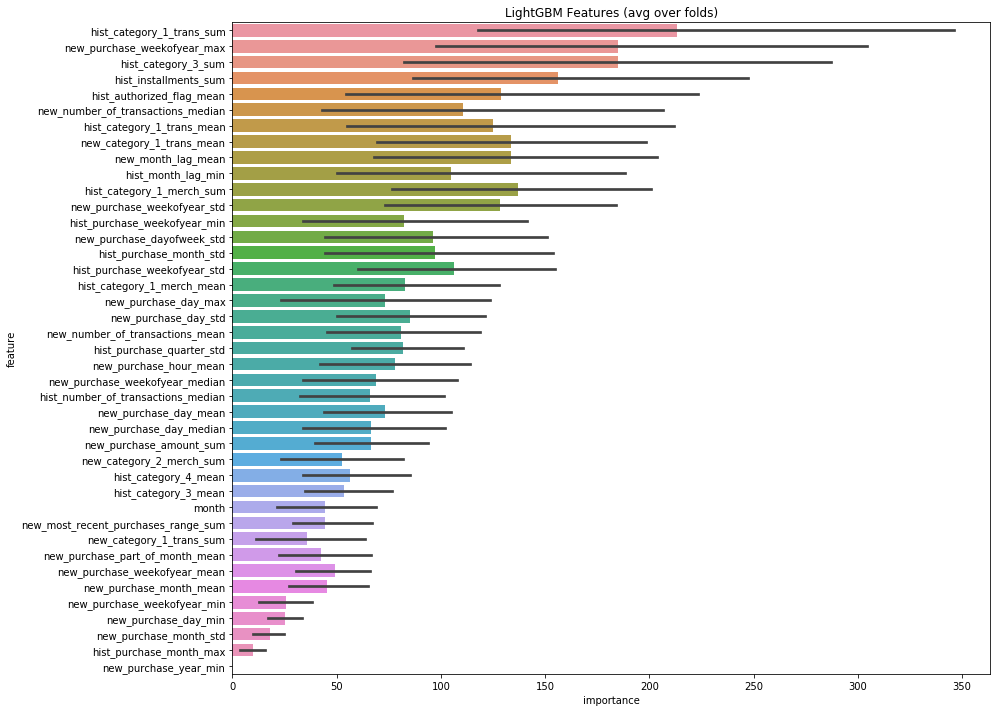

In [51]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 10))
sns.barplot(x="importance", y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [52]:
clf.save_model('models/outlier_detector_CV0.0844.txt')

In [53]:
lightgbm_outlier_pred = clf.predict(df_test[cols])

#### Random Forest

In [24]:
clf = RandomForestClassifier(verbose=1)
clf.fit(X, y)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.8s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [31]:
df_test_clean = df_test.dropna(axis=0, how='any')

In [32]:
randomforest_outlier_pred = clf.predict(df_test_clean[all_trainable_cols])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [33]:
randomforest_outlier_pred.sum()

14

In [58]:
outlier_card_ids = []
for i in range(len(randomforest_outlier_pred)):
    if randomforest_outlier_pred[i] == 1:
        print('{:,}. card_id: {}'.format(i, df_test_clean['card_id'].iloc[i]))
        outlier_card_ids.append(df_test_clean['card_id'].iloc[i])

1,188. card_id: C_ID_bfe02ddf33
1,942. card_id: C_ID_bd59e054f3
3,678. card_id: C_ID_695b445408
4,095. card_id: C_ID_ed0fd7dba8
4,674. card_id: C_ID_3d32bc9241
9,290. card_id: C_ID_a8bc0305ea
13,838. card_id: C_ID_0be3fb41d2
14,872. card_id: C_ID_aae50409e7
29,900. card_id: C_ID_d706b6696a
32,399. card_id: C_ID_75519a6d74
57,694. card_id: C_ID_072db63011
67,022. card_id: C_ID_1b9fcd49d7
78,571. card_id: C_ID_0c22eb865e
87,384. card_id: C_ID_4cdcd7bbb1


In [59]:
outlier_card_ids

['C_ID_bfe02ddf33',
 'C_ID_bd59e054f3',
 'C_ID_695b445408',
 'C_ID_ed0fd7dba8',
 'C_ID_3d32bc9241',
 'C_ID_a8bc0305ea',
 'C_ID_0be3fb41d2',
 'C_ID_aae50409e7',
 'C_ID_d706b6696a',
 'C_ID_75519a6d74',
 'C_ID_072db63011',
 'C_ID_1b9fcd49d7',
 'C_ID_0c22eb865e',
 'C_ID_4cdcd7bbb1']

#### Logistic regression

In [57]:
clf = LogisticRegression(verbose=1)
clf.fit(X, y)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=1, warm_start=False)

In [58]:
logistic_regression_outlier_pred = clf.predict(df_test[features].dropna(axis=0, how='any'))

In [59]:
logistic_regression_outlier_pred.sum()

6

### Ensembling

In [26]:
df_test.shape

(123623, 246)

In [ ]:
lightgbm_outlier_pred.shape

In [27]:
randomforest_outlier_pred.shape

(92944,)

In [28]:
logistic_regression_outlier_pred.shape

(92944,)

## LightGBM

In [61]:
clf = lgb.Booster(model_file='models/lightgbm_all.txt')

In [62]:
drops = ['card_id', 'first_active_month', 'target', 'outlier']
use_cols = [c for c in df_train.columns if c not in drops]
features = list(df_train[use_cols].columns)

In [63]:
predictions = clf.predict(df_test[features])

In [69]:
df_sub = pd.DataFrame({
    "card_id": df_test["card_id"].values
})
df_sub["target"] = predictions

In [83]:
df_sub[df_sub['card_id'] == 'C_ID_bfe02ddf33']['target'].values[0]
#df_sub[df_sub['card_id'] == 'C_ID_bfe02ddf33']['target'].loc[0]

-3.852057510050656

In [87]:
for i in range(len(outlier_card_ids)):
    print('The value of {} is {}'.format(outlier_card_ids[i], df_sub.loc[df_sub['card_id'] == outlier_card_ids[i], 'target'].values[0]))
    df_sub.loc[df_sub['card_id'] == outlier_card_ids[i], 'target'] = -33.218750
    
    #df_sub[df_sub['card_id'] == outlier_card_ids[i]]['target'] = -33.218750

The value of C_ID_bfe02ddf33 is -3.852057510050656
The value of C_ID_bd59e054f3 is -6.099381743303412
The value of C_ID_695b445408 is -5.684009590971966
The value of C_ID_ed0fd7dba8 is -3.623241519617461
The value of C_ID_3d32bc9241 is -5.879386068724139
The value of C_ID_a8bc0305ea is -5.374199240004434
The value of C_ID_0be3fb41d2 is -5.052975255462143
The value of C_ID_aae50409e7 is -6.150586595247187
The value of C_ID_d706b6696a is -5.701580949869356
The value of C_ID_75519a6d74 is -5.983826004623256
The value of C_ID_072db63011 is -5.986518822437147
The value of C_ID_1b9fcd49d7 is -4.896014551544255
The value of C_ID_0c22eb865e is -6.347456295208643
The value of C_ID_4cdcd7bbb1 is -5.82605980549829


In [88]:
len(df_sub[df_sub['target'] < -30])

14

In [89]:
df_sub.to_csv("output/lgbm_rf_outliers.csv", index=False)

LB score: 5.994